# Visualize the results of mapping a mixed RNA-seq sample against bacteria and phage. 

1. What fraction/percent of the sample mapped to each reference genome?
2. What locations of the phage reference genomes had the greatest read coverage?

## Setup

In [1]:
library(readr)
library(dplyr, warn.conflicts = F)
library(ggplot2)
library(ggtext)

In [2]:
setwd("..")

In [3]:
# use Arcadia brand font if present
if(file.exists("inputs/SuisseIntl-Regular.otf")){
  library(showtext)
  font_add("SuisseIntl", 
           regular = "inputs/SuisseIntl-Regular.otf",
           bold = "inputs/SuisseIntl-Bold.otf", 
           italic = "inputs/SuisseIntl-RegularItalic.otf")
  showtext::showtext_auto()
  theme_arcadia <- theme_classic() +
    theme(text = element_text(family = "SuisseIntl"))
} else {
  theme_arcadia <- theme_classic()
}

Loading required package: sysfonts

Loading required package: showtextdb



## Percent plotted

### Combined

In [4]:
reference_df <- data.frame(reference = c("NC_000964.3", "NZ_CP014269.1", "NC_000866.4", "NC_011421.1"),
                           name = c("*Bacillus subtilis* strain 168", "*Escherichia coli* strain B", "Phage T4", "Phage SPO1"), 
                           class = c("Bacteria", "Bacteria", "Phage", "Phage"),
                           system = c("bsub", "ecoli", "ecoli", "bsub"))

In [5]:
idxstats <- read_tsv("outputs/bwa_align/J1.idxstats", col_names = c("reference", "length", "num_mapped", "num_unmapped"), show_col_types = F) %>%
  left_join(reference_df, by = "reference") %>%
  mutate(total_reads = sum(num_mapped, num_unmapped),
         percent_mapped = (num_mapped/total_reads)*100)

Warning message in do_once((if (is_R_CMD_check()) stop else warning)("The function xfun::isFALSE() will be deprecated in the future. Please ", :
“The function xfun::isFALSE() will be deprecated in the future. Please consider using base::isFALSE(x) or identical(x, FALSE) instead.”


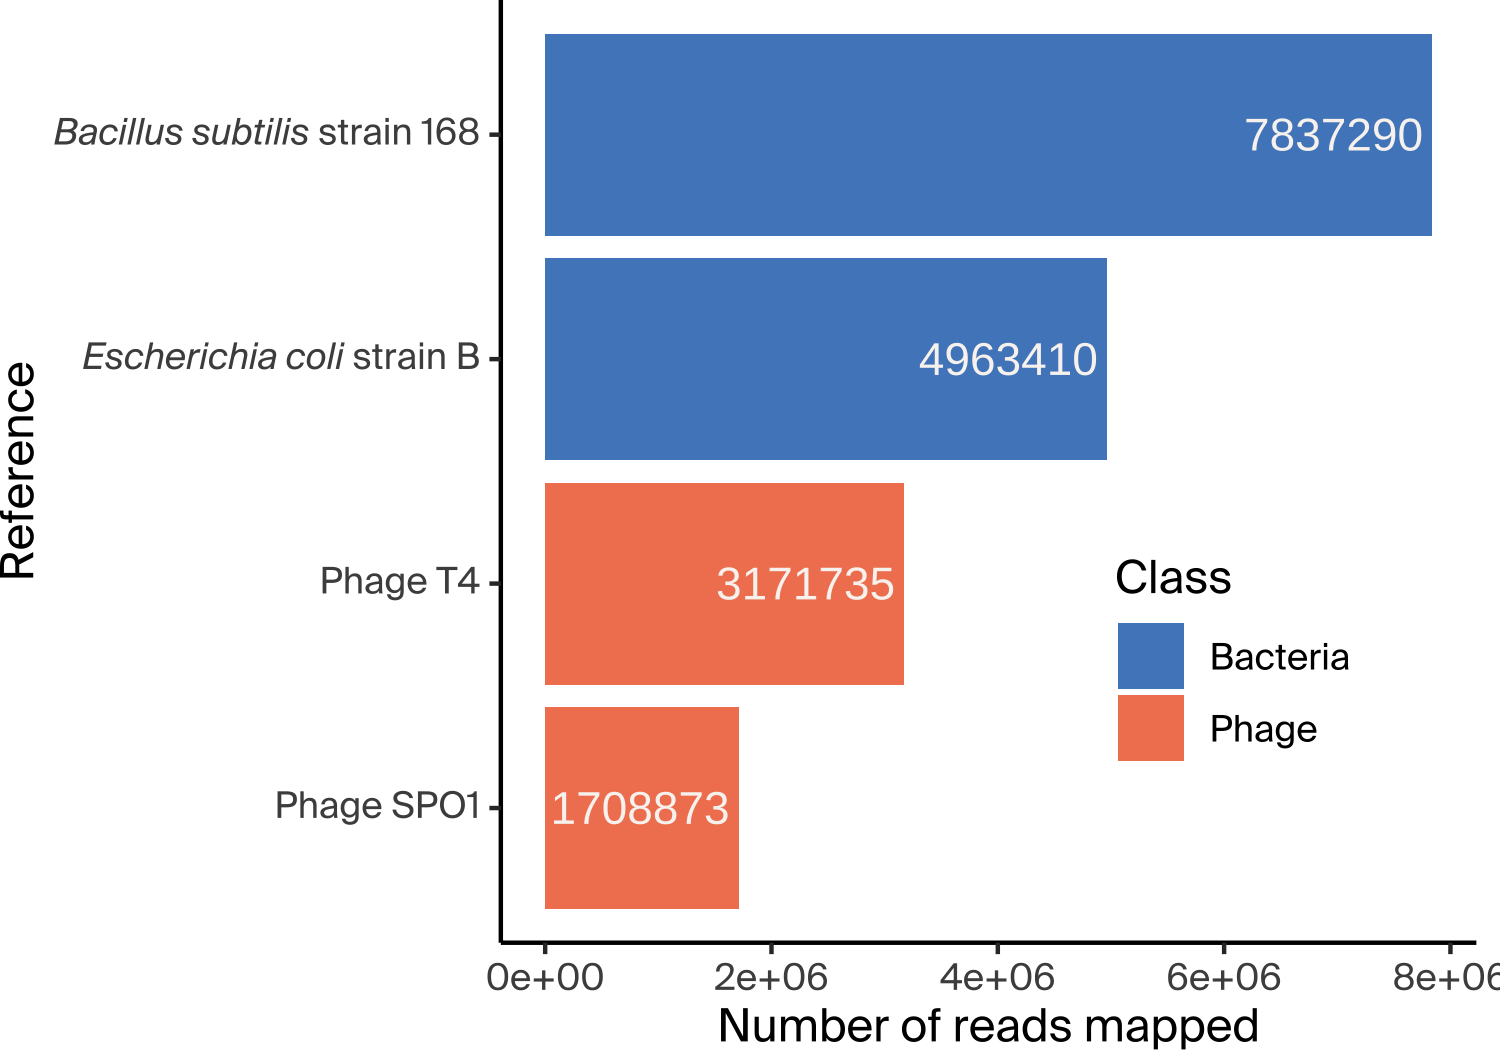

In [6]:
options(repr.plot.width = 5, repr.plot.height = 3.5, repr.plot.res = 300)

# number of reads mapped
ggplot(idxstats %>% filter(!is.na(name)), 
      aes(x = reorder(name, num_mapped), y = num_mapped, fill = class)) +
  geom_col() +
  geom_text(aes(label = num_mapped), hjust = 1.05, colour = "#F8F4F1") +
  theme_arcadia +
  coord_flip() +
  labs(y = "Number of reads mapped", fill = "Class", x = "Reference") +
  scale_fill_manual(values = c("#5088C5", "#F28360"),
                    labels = c("Bacteria", "Phage")) +
  theme(axis.text.y = ggtext::element_markdown(),
        legend.position = c(0.75, 0.3),
        plot.margin = margin(, .2, , , "cm"))

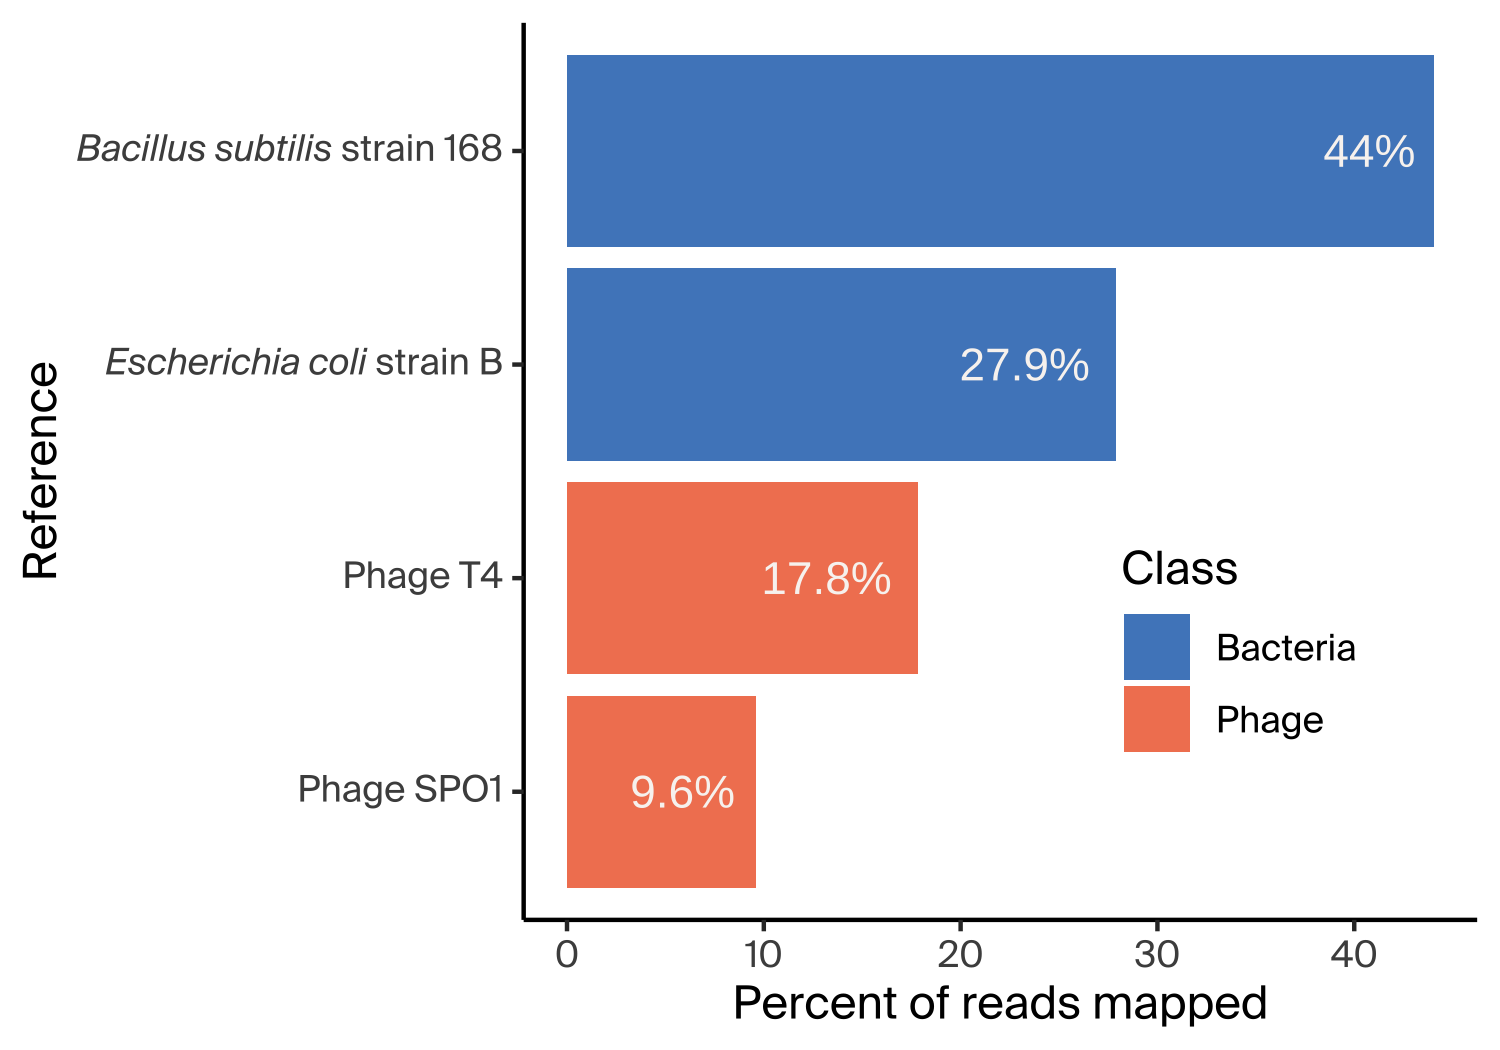

In [7]:
# percent of reads
ggplot(idxstats %>% filter(!is.na(name)), 
       aes(x = reorder(name, percent_mapped), y = percent_mapped, fill = class)) +
  geom_col() +
  geom_text(aes(label = paste0(round(percent_mapped, digits = 1), "%")), hjust = 1.2, colour = "#F8F4F1") +
  theme_arcadia +
  coord_flip() +
  labs(y = "Percent of reads mapped", fill = "Class", x = "Reference") +
  scale_fill_manual(values = c("#5088C5", "#F28360"),
                    labels = c("Bacteria", "Phage")) +
  theme(axis.text.y = ggtext::element_markdown(),
        legend.position = c(0.75, 0.3))

### Separate

In [8]:
# redefine plot dimensions
options(repr.plot.width = 4, repr.plot.height = 3.5, repr.plot.res = 300)

# create a function to plot a percentage bar plot for each system
plt_perc <- function(data){
  ggplot(data, aes(x = reorder(name, percent_mapped_system), y = percent_mapped_system, fill = class)) +
    geom_col() +
    geom_text(aes(label = paste0(round(percent_mapped_system, digits = 1), "%")), vjust = 2, colour = "#F8F4F1") +
    theme_arcadia +
    labs(y = "Percent of reads mapped", fill = "Class", x = "Reference") +
    scale_fill_manual(values = c("#5088C5", "#F28360"),
                      labels = c("Bacteria", "Phage")) +
    theme(axis.text.x = ggtext::element_markdown(),
          legend.position = c(0.2, 0.8),
          strip.background = element_blank(),
          strip.text.x = element_blank())
}

In [9]:
# re-calculate percentages within pairs
idxstats2 <- idxstats %>% 
  filter(!is.na(name)) %>% 
  group_by(system) %>%
  mutate(total_reads_system = sum(num_mapped, num_unmapped),
         percent_mapped_system = (num_mapped/total_reads_system)*100)

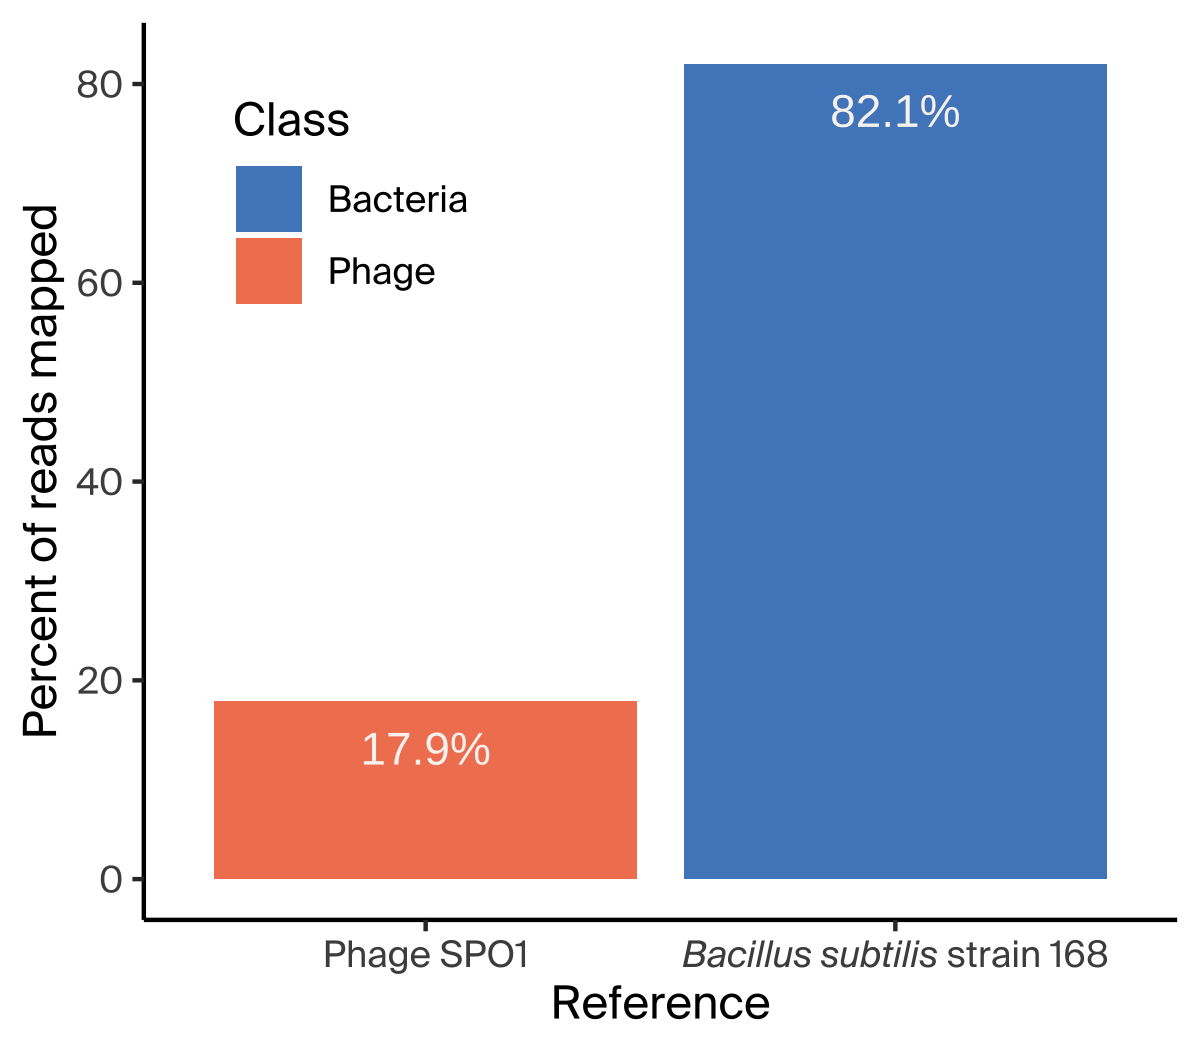

In [10]:
plt_perc_bsub <- plt_perc(idxstats2 %>% filter(system == "bsub"))
plt_perc_bsub

In [11]:
pdf("figures/percent_bsub.pdf", width = 4, height = 3.5)
plt_perc_bsub
dev.off()
png("figures/percent_bsub.png", width = 4, height = 3.5, units = "in", res = 300)
plt_perc_bsub
dev.off()

pdf 
  2

pdf 
  2

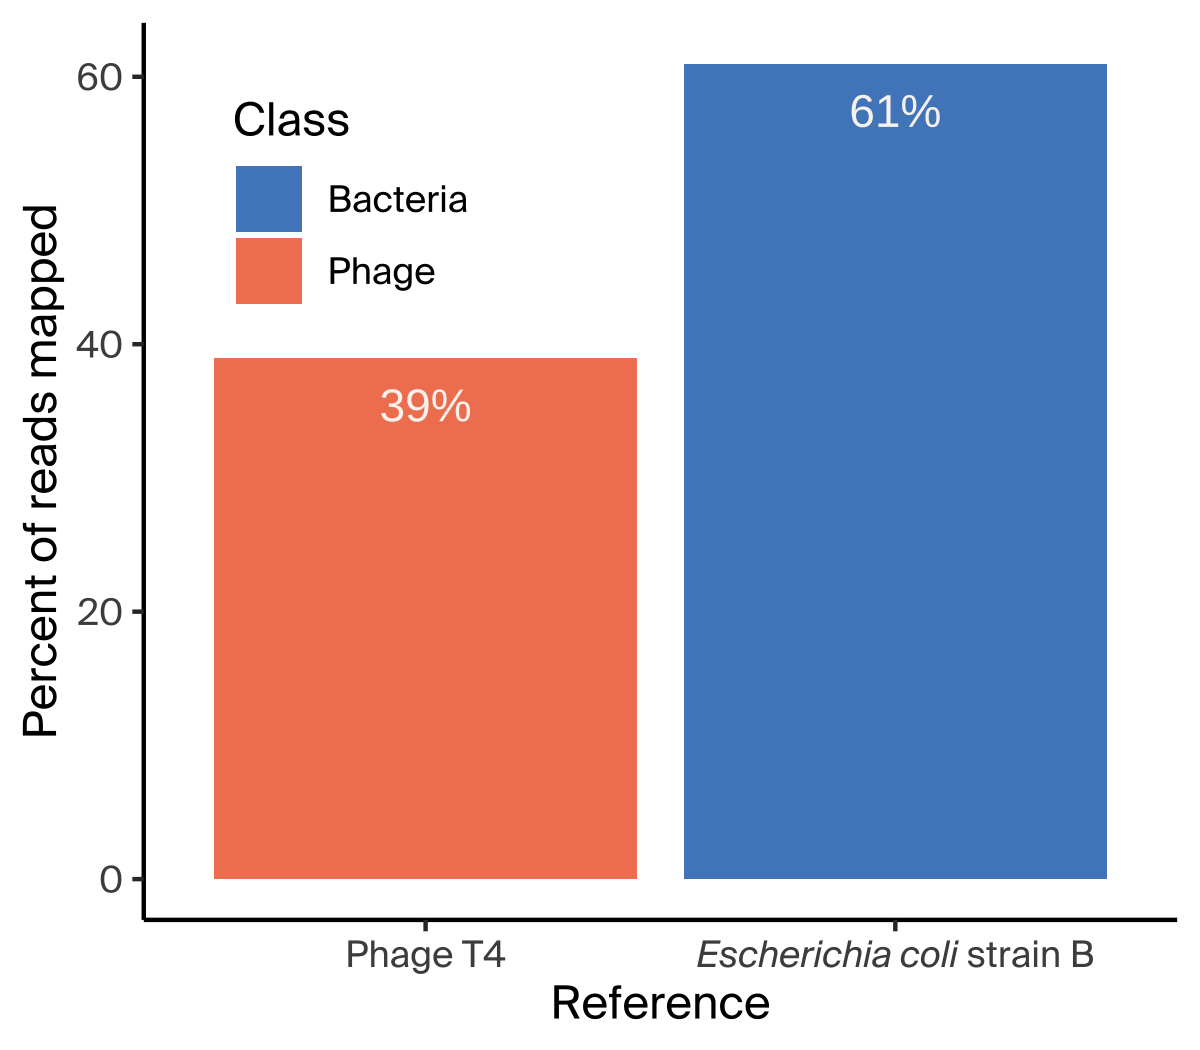

In [12]:
plt_perc_ecoli <- plt_perc(idxstats2 %>% filter(system == "ecoli"))
plt_perc_ecoli

In [13]:
pdf("figures/percent_ecoli.pdf", width = 4, height = 3.5)
plt_perc_ecoli
dev.off()
png("figures/percent_ecoli.png", width = 4, height = 3.5, units = "in", res = 300)
plt_perc_ecoli
dev.off()

pdf 
  2

pdf 
  2

## Depth plots

In [14]:
depth <- read_tsv("outputs/bwa_align/J1.depth", col_names = c("reference", "position", "depth"), show_col_types = F) %>%
  left_join(reference_df, by = "reference") %>%
  filter(class %in% "Phage")

In [15]:
options(repr.plot.width = 9, repr.plot.height = 3.5, repr.plot.res = 300)

# create a function to plot a depth of sequencing at each position in each phage genome
plt_depth <- function(data, title){
  ggplot(data, aes(x = position, y = depth)) +
    #geom_point(size = 0.5, alpha = .25) +
    geom_line() +
    theme_arcadia +
    theme(plot.title.position = "plot",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 17),
          plot.title = element_text(size = 19)) +
    labs(title = title,
         x = "Position (base pair)",
         y = "Read depth")
}

In [16]:
plt_depth_t4 <- plt_depth(depth %>% filter(name %in% c("Phage T4")), title = "Phage T4 coverage depth across genome")

In [17]:
pdf("figures/depth_t4.pdf", width = 9, height = 3.5)
plt_depth_t4
dev.off()
png("figures/depth_t4.png", width = 9, height = 3.5, units = "in", res = 300)
plt_depth_t4
dev.off()

pdf 
  2

pdf 
  2

In [18]:
plt_depth_spo1 <- plt_depth(depth %>% filter(name %in% c("Phage SPO1")), title = "Phage SPO1 coverage depth across genome")

In [19]:
pdf("figures/depth_spo1.pdf", width = 9, height = 3.5)
plt_depth_spo1
dev.off()
png("figures/depth_spo1.png", width = 9, height = 3.5, units = "in", res = 300)
plt_depth_spo1
dev.off()

pdf 
  2

pdf 
  2

## Software & versions

In [20]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur/Monterey 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pltenv/lib/libopenblasp-r0.3.21.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] showtext_0.9-5 showtextdb_3.0 sysfonts_0.8.8 ggtext_0.1.2   ggplot2_3.4.0 
[6] dplyr_1.1.0    readr_2.1.3   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.10      pillar_1.8.1     compiler_4.1.3   base64enc_0.1-3 
 [5] tools_4.1.3      bit_4.0.5        digest_0.6.31    uuid_1.1-0      
 [9] jsonlite_1.8.4   evaluate_0.20    lifecycle_1.0.3  tibble_3.1.8    
[13] gtable_0.3.1     pkgconfig_2.0.3  rlang_1.0.6      IRdisplay_1.1   
[17] cli_3.6.0        commonmark_1.8.1 parallel_4.1.3   IRkernel_1.3.1  
[21] xfun_0.37        fastmap_1.1.0    stringr_